In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
#import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
matplotlib.rcParams['figure.figsize'] = (8.08, 5.)
matplotlib.rcParams['xtick.labelsize'] = 20.0
matplotlib.rcParams['ytick.labelsize'] = 20.0
matplotlib.rcParams['axes.labelsize'] = 26.0
matplotlib.rcParams['legend.fontsize'] = 13
matplotlib.rcParams['font.family']= 'Times New Roman'
matplotlib.rcParams['font.sans-serif']= ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex']= False
matplotlib.rcParams['mathtext.fontset']= 'stixsans'

#sns.set(rc={'figure.figsize':(11.7,8.27)})

import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)
#sns.set_context('notebook')
#sns.set(style="white", palette="muted")
from scipy import stats
#import get_wavelet_params as wp

import pystan
from scipy.interpolate import interp1d
from collections import OrderedDict
import pandas as pd
import tqdm
import scipy.stats as stats
%pylab inline
import arviz as az
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


### The most common reference for posterior predictive checks is the Gelman, Meng, Stern paper "POSTERIOR PREDICTIVE ASSESSMENT OF MODEL FITNESS VIA REALIZED DISCREPANCIES" http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf

### Gelmans "Bayesian Data Analysis" book has a very good discussion as well.

### Most paper references I am aware of are GW-specific, apologies.


The idea of posterior predictive checks is to assess a hierarchical model from how its predictions compare to what we observed. There are a number of advantages to this approach

1. It's relatively computationally efficient.
2. It takes the comparison to the data space, ie. the space where the likelihood is written.
3. It is closely related to hierarchical inference and most of the intuition carries over.
4. It is not a Bayes Factor.

There are also disdvantages
1. Comparisons in the data space can be clunky. 
2. Can be conceptually challenging.

Below I have some simple examples of how to use some posterior predictive checks to assess hierarchical models. Some caveats

1. All likelihoods are gaussian.
2. All measurement uncertainties are the same.
3. Restricted to 1-D, though (almost) everything carries to N-D.
4. I will ignore selection effects, but will note where they would enter.

Let's start with a re-telling of Chris' example for why priors matter. We measure data $x$ with a uniform prior and a gaussian likelihood. But the data $x$ are drawn from a gaussian population. The mismatch between the prior and the population is a problem

In [66]:
# I have a gaussian population
mupop=0
sigmapop=1
# and make a number of measurements
Ndet=100
# with the same uncertainty
SNR=0.5

## The true values of x for each event are drawn from the gaussian population
xtrue=np.random.normal(mupop,sigmapop,Ndet)

## And I have some scatter due detector noise
xobs=xtrue+np.random.normal(0,SNR,Ndet)

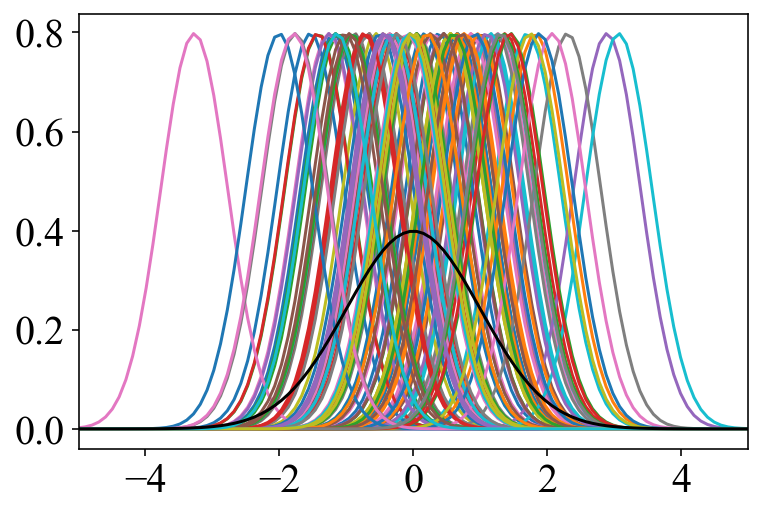

In [67]:
## Let's assume a uniform prior, so this is the posterior for each event
x = np.linspace(-5, 5, 100)
for i in range(Ndet):
    x = np.linspace(-5, 5, 100)
    plt.plot(x, stats.norm.pdf(x, xobs[i], SNR))
plt.plot(x, stats.norm.pdf(x, mupop, sigmapop),c='k')
plt.xlim(-5,5)
plt.show()

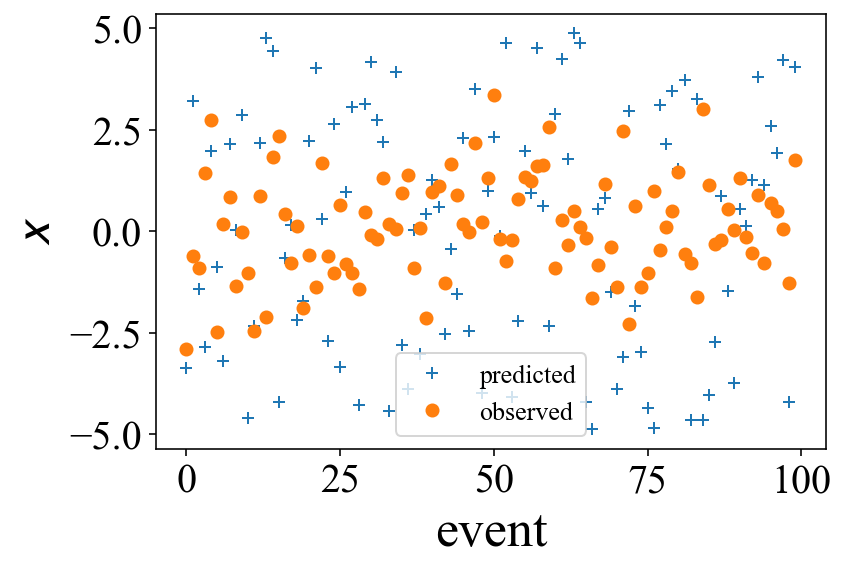

In [17]:
## The idea of posterior predictive checks is to predict new data. I have a uniform prior, so I have assumed that x
## is uniformly distributed
Nr=1
for j in range(Nr):
    xpred=np.random.uniform(-5,5,Ndet) ## I have assumed that x is uniformly distributed
    plt.plot(xpred,'+',label='predicted')
    
    xobsr=np.random.normal(xobs,SNR) ## draw a random sample from the observed posterior
    plt.plot(xobsr,'o',label='observed')
plt.legend()
plt.xlabel('event')
plt.ylabel('x')
plt.show()

### The observed and the predicted population clearly don't match. I am predicting a lot more large x values than what I'm seeing. 

In this case there's an obvious problem, but sometimes a subtle mismatch can be due to the realization of either the predicted or the observed data. So draw many realizations

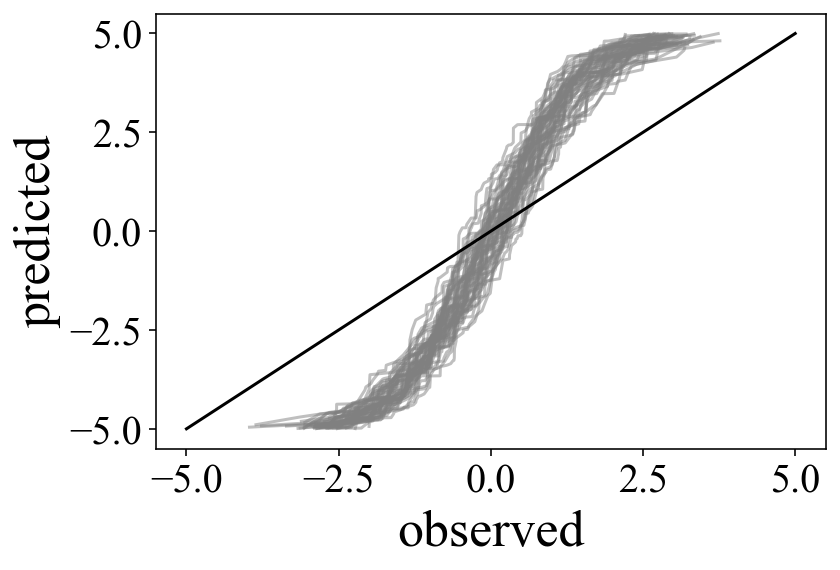

In [18]:
Nr=50
for j in range(Nr):
    xpred=np.random.uniform(-5,5,Ndet) ## predicted data
    xobsr=np.random.normal(xobs,SNR) ## observed data
    xobsr.sort()
    xpred.sort()
    plt.plot(xobsr,xpred,c='grey',alpha=0.5)
x = np.linspace(-5, 5, 100)
plt.plot(x,x,'k')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

This is sometimes referred to as a lightning plot

### So let's try to model the x distribution hierarchically. Effectively we are looking for the prior that diagonalizes the lightning plot and can predict data that match the observations

In [23]:
## this fits a gaussian model with some mu and some sigma. 
## it also directly returns the posterior for the true parameters
model_GR = pystan.StanModel(file='Gaussian.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70b5732dfd0e0bd652cfa4f192f6d1ed NOW.


In [24]:
with open('Gaussian.stan', 'r') as f:
    print(f.read())

data {
  int ndet;
  vector[ndet] xobs;
  vector[ndet] sigma_xobs;
}

parameters {
  real mu;  
  real<lower=0> sigma;
  vector[ndet] unit;
}

transformed parameters {
  vector[ndet] xtrue;
  xtrue = mu+sigma*unit;
}

model {
  unit ~ normal(0,1);
  xobs ~ normal(xtrue, sigma_xobs);
}



In [25]:
Data = {'ndet': Ndet,
        'xobs': xobs,
        'sigma_xobs': np.full(Ndet,SNR)}   

### The fit here ignores selection effects. I am assuming that all values of $(\mu,\sigma)$ produce the same number of detectable events

In [31]:
Fit = model_GR.sampling(data=Data)#, iter=4000, thin=100, 
                                       # control={"adapt_delta" : 0.95,"max_treedepth":15})
Fit
az.to_netcdf(Fit, 'G.nc')

'G.nc'

In [32]:
fit = az.from_netcdf('G.nc')

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'unit'}>,
        <AxesSubplot:title={'center':'unit'}>],
       [<AxesSubplot:title={'center':'xtrue'}>,
        <AxesSubplot:title={'center':'xtrue'}>]], dtype=object)

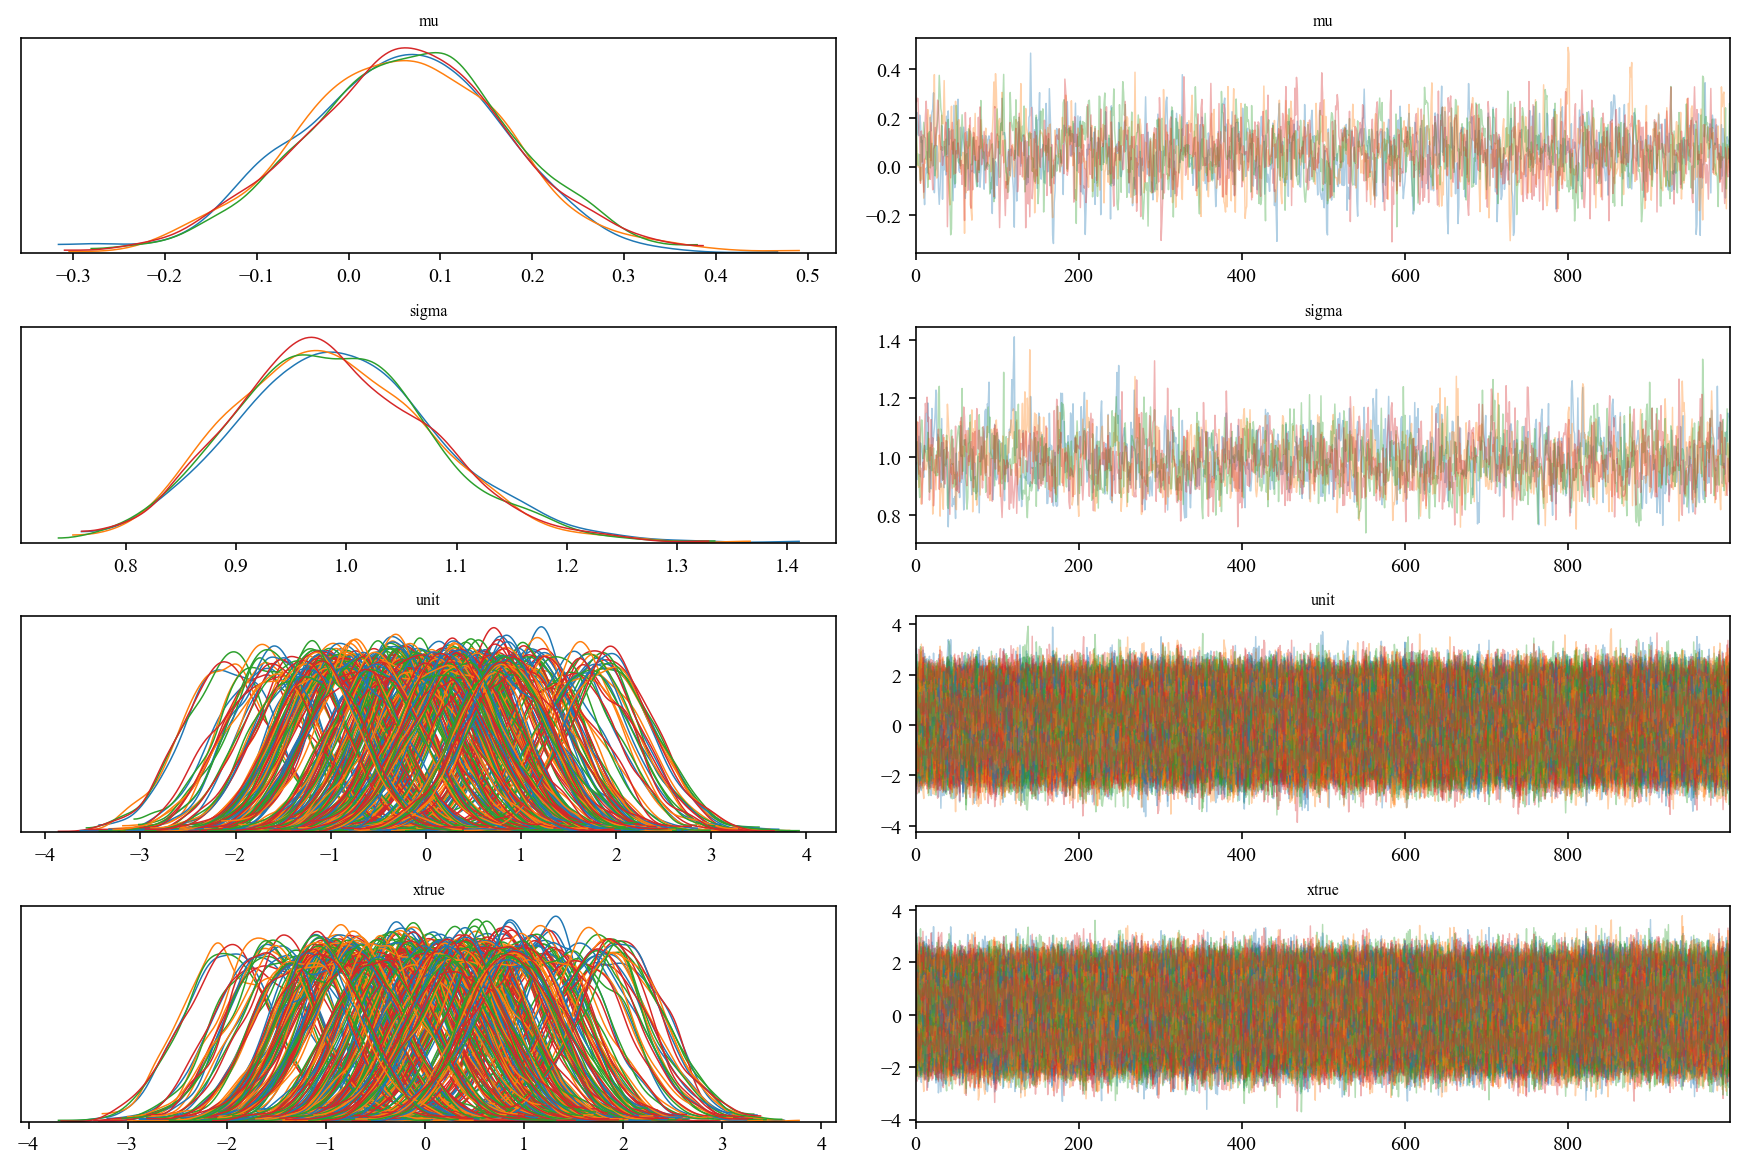

In [33]:
## plot the posteriors
az.plot_trace(fit, compact=True,var_names=['mu', 'sigma', 'unit', 'xtrue'])

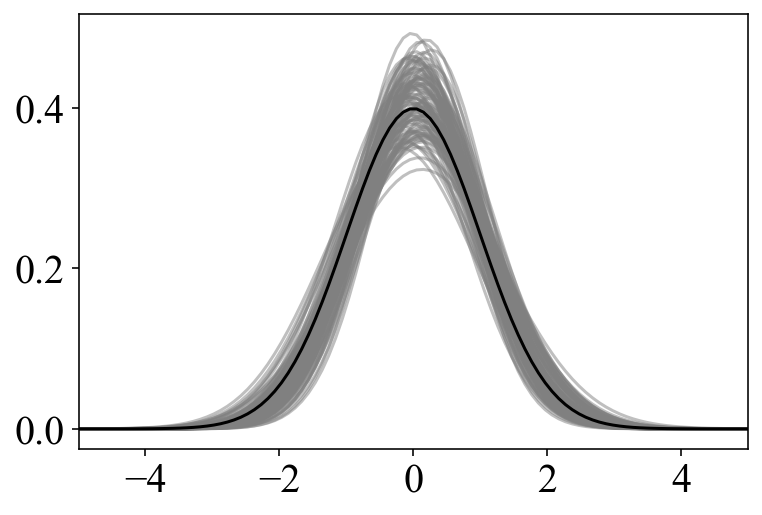

In [34]:
## each (mu,sigma) sample gives you a model for the population
x = np.linspace(-5, 5, 100)
for i in range(100):
    irand=int(np.random.uniform(0,len(fit.posterior.mu.values.flatten())))
    murand=fit.posterior.mu.values.flatten()[irand]
    sigmarand=fit.posterior.sigma.values.flatten()[irand]
    plt.plot(x, stats.norm.pdf(x, murand, sigmarand),c='grey',alpha=0.5)
plt.plot(x, stats.norm.pdf(x, mupop, sigmapop),c='k')
plt.xlim(-5,5)
plt.show()

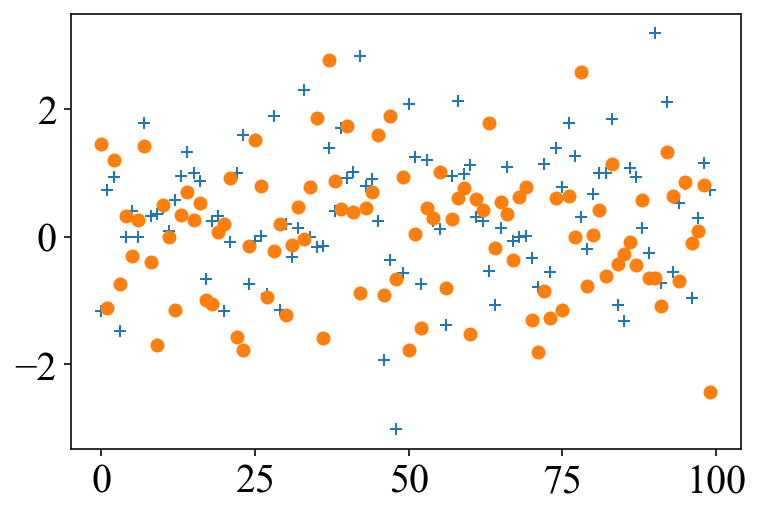

In [51]:
## Let's draw one realization of predicted data
irand=int(np.random.uniform(0,len(fit.posterior.mu.values.flatten())))
murand=fit.posterior.mu.values.flatten()[irand]
sigmarand=fit.posterior.sigma.values.flatten()[irand]
Nr=1
for j in range(Nr):
    xpred=np.random.normal(murand,sigmarand,Ndet) ## the predicted data now come from the hierachical model
    plt.plot(xpred,'+')
    xobs=fit.posterior.xtrue[int((irand-(irand%1000))/1000),irand%1000].values ## and the corresponding observed data
    random.shuffle(xobs)
    plt.plot(xobs,'o')
plt.show()

We have two sources of randomness
1. The realization of $x$ from the population
2. The population distribution which we do not know exactly. Marginalize.

#### If the observation has a selection effect, we'd need to include it both in the predicted and in the observed data

The predicted data below come directly from the population model. 

The observed data need a bit of care. Here we want the observed data as predicted by the population model. So we need
$$
p(x_i|d_1,d_2...)\sim p(d_i|x_i)\int d\lambda p(x|\lambda) p(\lambda|d_1,d_2...)
$$
and not 
$$
p(x_i|d_i) \sim p(d_i|x_i) p(x_i)
$$

The difference between the two is the prior. The former uses the population model as the prior, the latter uses a flat prior (the prior integral above changes if you have a selection effect).

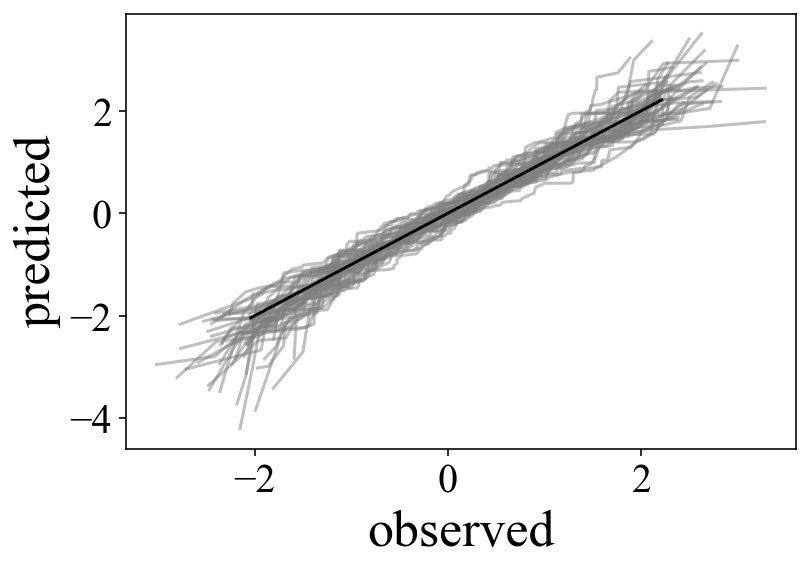

In [53]:
Nr=50
for j in range(Nr):
    irand=int(np.random.uniform(0,len(fit.posterior.mu.values.flatten()))) ## predicted
    murand=fit.posterior.mu.values.flatten()[irand]
    sigmarand=fit.posterior.sigma.values.flatten()[irand]
    xpred=np.random.normal(murand,sigmarand,Ndet)
    xobs=fit.posterior.xtrue[int((irand-(irand%1000))/1000),irand%1000].values ## observed
    xobs.sort()
    xpred.sort()
    plt.plot(xobs,xpred,c='grey',alpha=0.5)
x = np.linspace(np.min(xobs), np.max(xobs), 100)
plt.plot(x,x,'k')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

#### Beautifully diagonal. The hiearchical model is the prior that P-p diagonalizes the posterior 

### Everything above is gaussian and works as expected. Let's see what to expect when the population model cannot match the true population. 

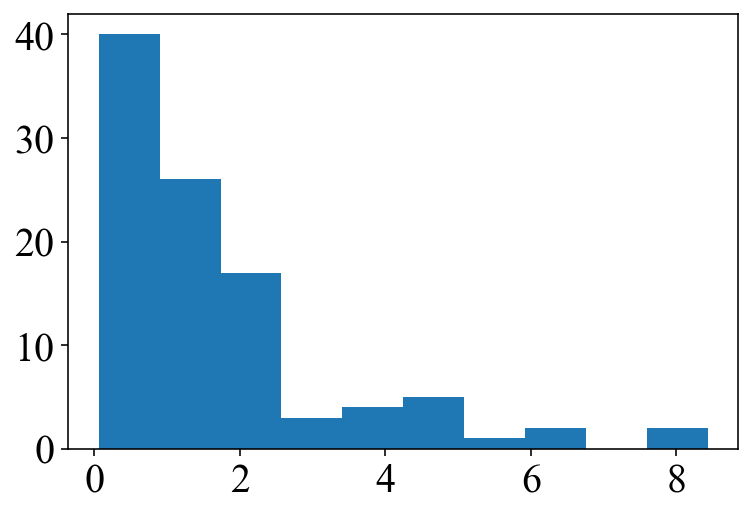

In [54]:
Ndet=100
xtrue=np.random.lognormal(mupop,sigmapop,Ndet) ## the population is drawn from a lognormal distribution
xobs=xtrue+np.random.normal(0,SNR,Ndet)
plt.hist(xtrue)
plt.show()

In [57]:
Data = {'ndet': Ndet,
        'xobs': xobs,
        'sigma_xobs': np.full(Ndet,SNR)}   

In [58]:
Fit = model_GR.sampling(data=Data)
Fit
az.to_netcdf(Fit, 'logG.nc')

'logG.nc'

In [59]:
fit = az.from_netcdf('logG.nc')

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'unit'}>,
        <AxesSubplot:title={'center':'unit'}>],
       [<AxesSubplot:title={'center':'xtrue'}>,
        <AxesSubplot:title={'center':'xtrue'}>]], dtype=object)

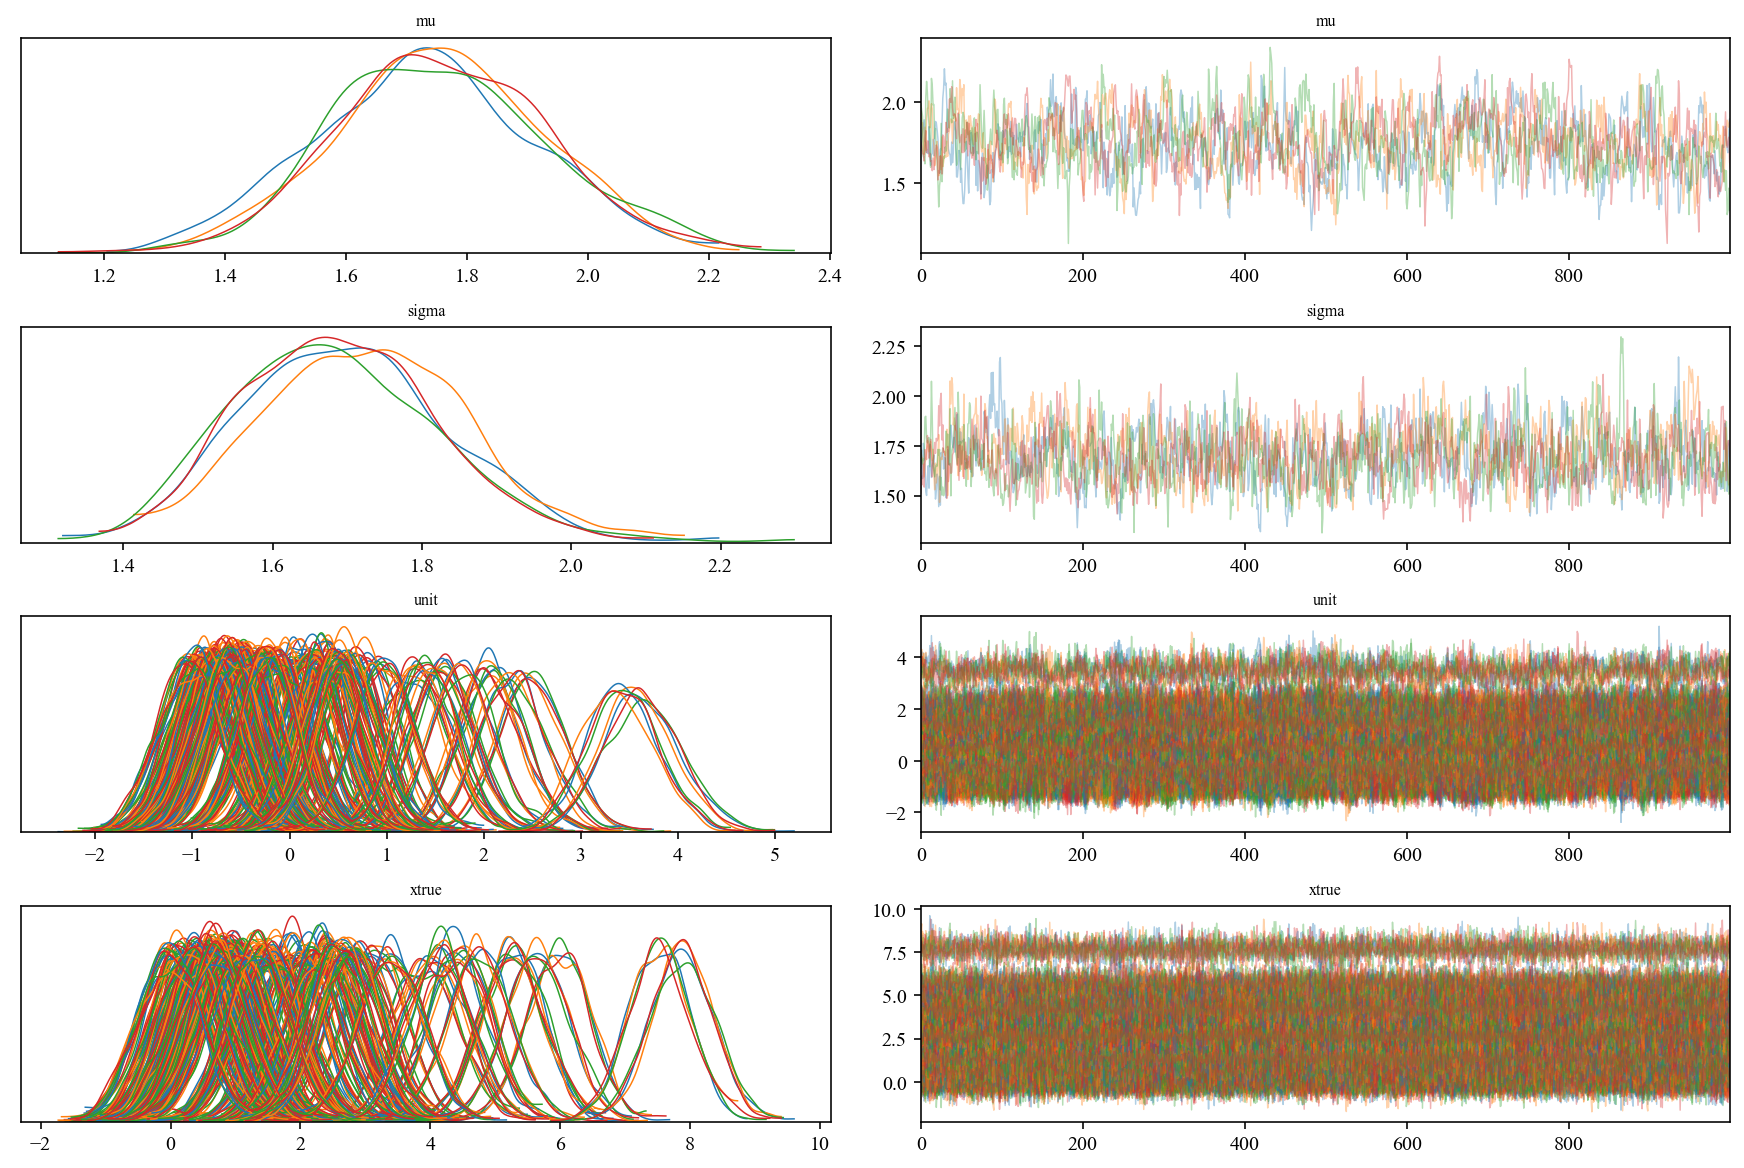

In [61]:
az.plot_trace(fit, compact=True,var_names=['mu', 'sigma', 'unit', 'xtrue'])

### There's no clue in the chains above that the population model is bad

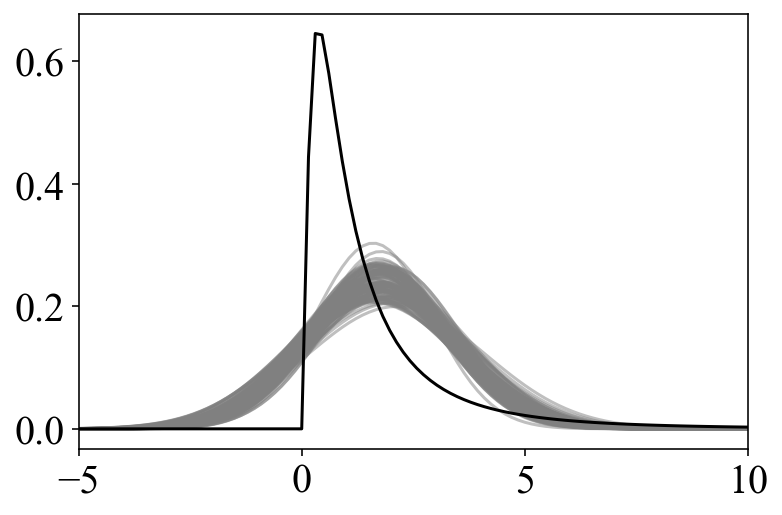

In [62]:
## The gaussian population will obviously not be a good model for the lognormal population. 
## But unfortunately we do not know what the true population is
x = np.linspace(-5, 10, 100)
for i in range(100):
    irand=int(np.random.uniform(0,len(fit.posterior.mu.values.flatten())))
    murand=fit.posterior.mu.values.flatten()[irand]
    sigmarand=fit.posterior.sigma.values.flatten()[irand]
    plt.plot(x, stats.norm.pdf(x, murand, sigmarand),c='grey',alpha=0.5)
plt.plot(x, stats.lognorm.pdf(x, sigmapop),c='k')
plt.xlim(-5,10)
#plt.yscale('log')
plt.show()

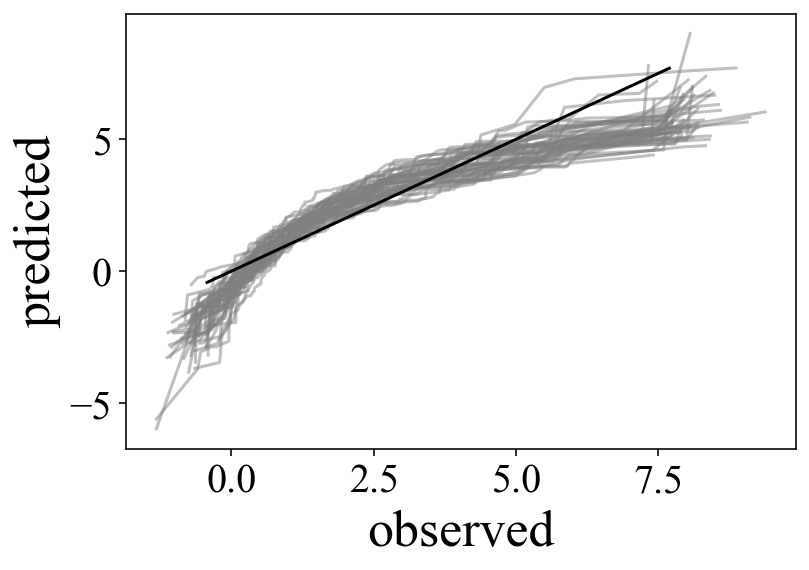

In [65]:
## The lightning plot gives us a pretty clear indication of trouble
Nr=50
for j in range(Nr):
    irand=int(np.random.uniform(0,len(fit.posterior.mu.values.flatten())))
    murand=fit.posterior.mu.values.flatten()[irand]
    sigmarand=fit.posterior.sigma.values.flatten()[irand]
    xpred=np.random.normal(murand,sigmarand,Ndet)
    xobs=fit.posterior.xtrue[int((irand-(irand%1000))/1000),irand%1000].values
    xobs.sort()
    xpred.sort()
    plt.plot(xobs,xpred,c='grey',alpha=0.5)
x = np.linspace(np.min(xobs), np.max(xobs), 100)
plt.plot(x,x,'k')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

### For the lightning plot the predicted data are computed assuming a gaussian population model, and the observed data have been computed assuming the *same* gaussian population prior. There is still a discrepancy